# Классификация с использованием SVM

In [66]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles

## Постановка задачи
Построить и протестировать классификатор с использованием:
- модельных данных;
- данных из репозитория (https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/).

In [98]:
# Начальное условие для генератора случайных чисел
np.random.seed(42)


# LaTeX
def formatted(s):
    return '$%s$' % s


# Построение графика
def graph(X, y, clf, title='', filename=''):
    fig = plt.figure(figsize=plt.figaspect(0.5))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='r')
    ax.set_title(title)
    fig.savefig("pictures/" + filename)
    plt.show()

## Сепарабельный случай (Hard margin)

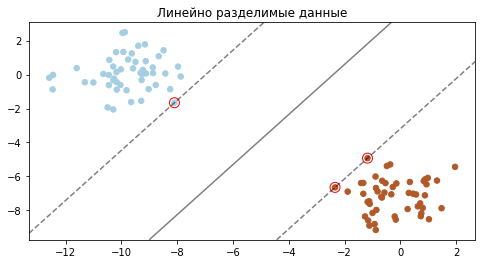

In [99]:
# Генерация
n = 100
X, y = make_blobs(n_samples=n, centers=2, random_state=9)

# Обучение и вывод результатов
clf = SVC(kernel='linear')
clf.fit(X, y)

graph(X, y, clf, 'Линейно разделимые данные', '1')

## Несепорабельный случай (Soft margin)

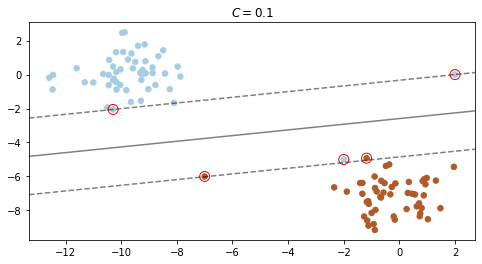

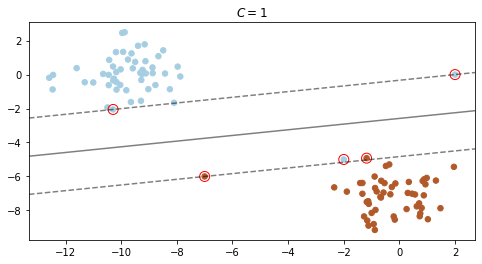

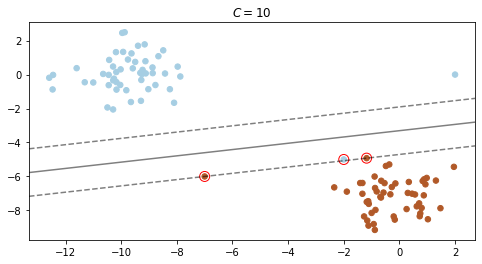

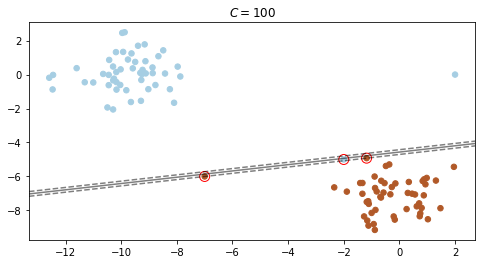

$C$,$M=\frac{2}{\left \| w \right \|}$
0.1,2.225921
1,2.217175
10,1.375664
100,0.137566


In [114]:
# Генерация
n = 100
X, y = make_blobs(n_samples=n, centers=2, random_state=9)

# Внесение выбросов
outliers_X = np.array([
        [-2, -5],
        [-7, -6],
        [2, 0]
    ])
outliers_y = np.array([
        0,
        1,
        0
    ]).T
X = np.append(X, outliers_X, axis=0)
y = np.append(y, outliers_y, axis=0)

table = pd.DataFrame(data=[], columns=[formatted(r"M=\frac{2}{\left \| w \right \|}")])
table.columns.name = formatted(r'C')

# Исследование при различных C
for C in [0.1, 1, 10, 100]:
    clf = SVC(kernel='linear', C=C)
    clf.fit(X, y)
    norm_w = np.sqrt(np.sum(clf.coef_ ** 2))
    M = 1 / norm_w
    table.loc[str(C)] = [M]

    graph(X, y, clf, formatted('C=' + str(C)), '2-%i'%C)

display(table)

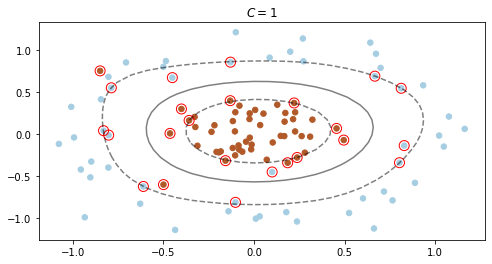

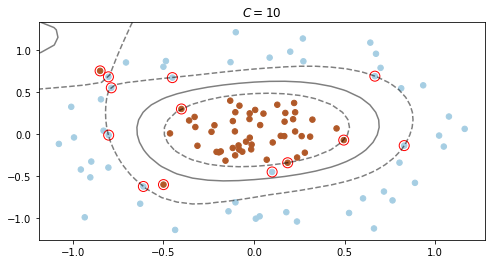

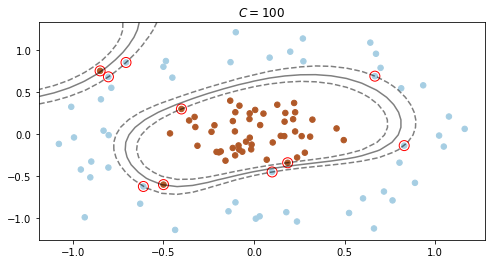

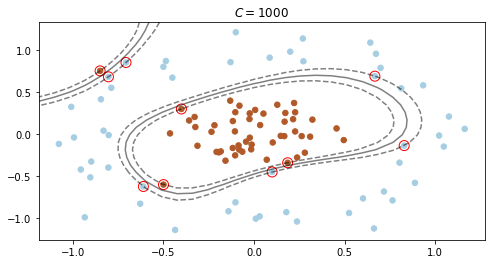

In [115]:
# Генерация
n = 100
X, y = make_circles(n_samples=n, factor=0.25, noise=0.15, random_state=9)

# Внесение выбросов
outliers_X = np.array([
        [-0.85, 0.75],
        [0.1, -0.45],
        [-0.5, -0.6]
    ])
outliers_y = np.array([
        1, 0, 1
    ]).T
X = np.append(X, outliers_X, axis=0)
y = np.append(y, outliers_y, axis=0)

# Исследование при различных C
for C in [1, 10, 100, 1000]:
    clf = SVC(kernel='rbf', C=C)
    clf.fit(X, y)
    
    graph(X, y, clf, formatted('C=' + str(C)), '3-%i'%C)

## Данные из репозитория

In [126]:
# Получение и считывание данных из файла в двумерный numpy-массив
def parse_file(filename):
    arr = []

    with open(filename) as file:
        for line in file:
            arr.append(list(map(int, line.strip().split())))

    return np.array(arr)


# Исследование на сетках по C и gamma
def analyze(X, y):
    # Вывод результатов
    def print_results(X_train, X_test, y_train, y_test, title):
        search.fit(X_train, y_train)
        y_pred_train = search.predict(X_train)
        y_pred_test = search.predict(X_test)
        
        print('*** ' + title + ' ***')
        print()
        print('Лучшая точность на обучающей выборке:', search.best_score_ * 100, '%')
        print('Оптимальные параметры: C =', search.best_params_['svc__C'], ', gamma =', search.best_params_['svc__gamma'])
        print('F1-оценка:', f1_score(y_train, y_pred_train))
        print()
        print('Точность на тесте:', accuracy_score(y_test, y_pred_test) * 100, '%')
        print('F1-оценка:', f1_score(y_test, y_pred_test))
        print()
        print()
        
    C_grid = [1, 10, 100, 1000]
    gamma_grid = [1e-1, 1e-2, 1e-3, 1e-4]
    
    # Разбитие на ТП и ТестП
    pca = PCA(n_components=3)
    X_reduced = pca.fit_transform(X)
    X_train, X_test, X_red_train, X_red_test, y_train, y_test = train_test_split(X, X_reduced, y, test_size=0.2, random_state=42)
    
    # Инициализация
    clf = make_pipeline(StandardScaler(), SVC())
    param_grid = {'svc__C': C_grid, 'svc__gamma': gamma_grid, 'svc__kernel': ['rbf']}
    search = GridSearchCV(clf, param_grid, cv=10)
    
    print_results(X_train, X_test, y_train, y_test, 'На полном наборе признаков')
    print_results(X_red_train, X_red_test, y_train, y_test, 'С главными компонентами')

    
# Чтение и преобразование данных в numpy-массивы
german = parse_file('data/german.data-numeric')
X, y = german[:, :-1], german[:, -1] - 1

# Анализ
analyze(X, y)

*** На полном наборе признаков ***

Лучшая точность на обучающей выборке: 76.75 %
Оптимальные параметры: C = 10 , gamma = 0.01
F1-оценка: 0.7447306791569087

Точность на тесте: 80.0 %
F1-оценка: 0.6153846153846154


*** С главными компонентами ***

Лучшая точность на обучающей выборке: 71.125 %
Оптимальные параметры: C = 100 , gamma = 0.01
F1-оценка: 0.10894941634241245

Точность на тесте: 71.5 %
F1-оценка: 0.06557377049180328


